Momentum strategy with 52-week screen
Price data from Yahoo Finance...

Portfolio Value vs Dow Jones Index (DJI) on first trading day of each month:
      date   cash  invested  total_value  total_value_no_commission  dji_value_from_100  portfolio_drawdown_pct  dji_drawdown_pct
2019-07-01 100.00      0.00       100.00                     100.00          100.000000                    0.00              0.00
2019-08-01 100.00      0.00       100.00                     100.00           99.498418                    0.00             -0.50
2019-09-03 100.00      0.00       100.00                     100.00           97.756483                    0.00             -2.24
2019-10-01  19.98     79.35        99.32                      99.35           99.459564                   -0.68             -0.54
2019-11-01  19.57     80.98       100.55                     100.67          102.357748                    0.00              0.00
2019-12-02   3.17     98.10       101.28                     101.45    

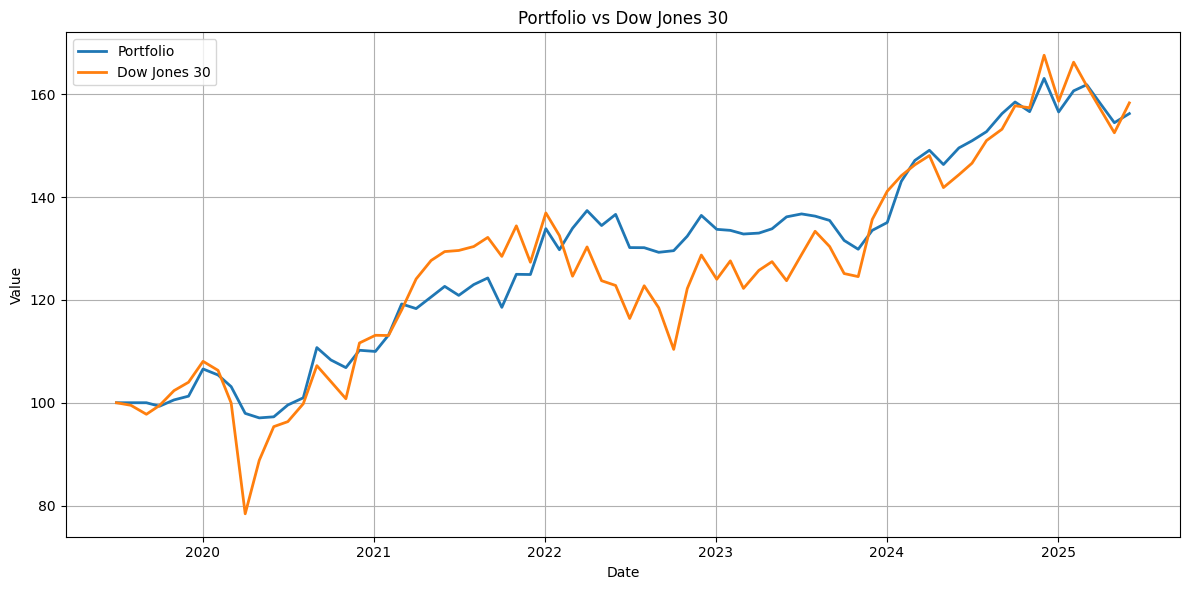


Generating Monthly Returns Heatmap...


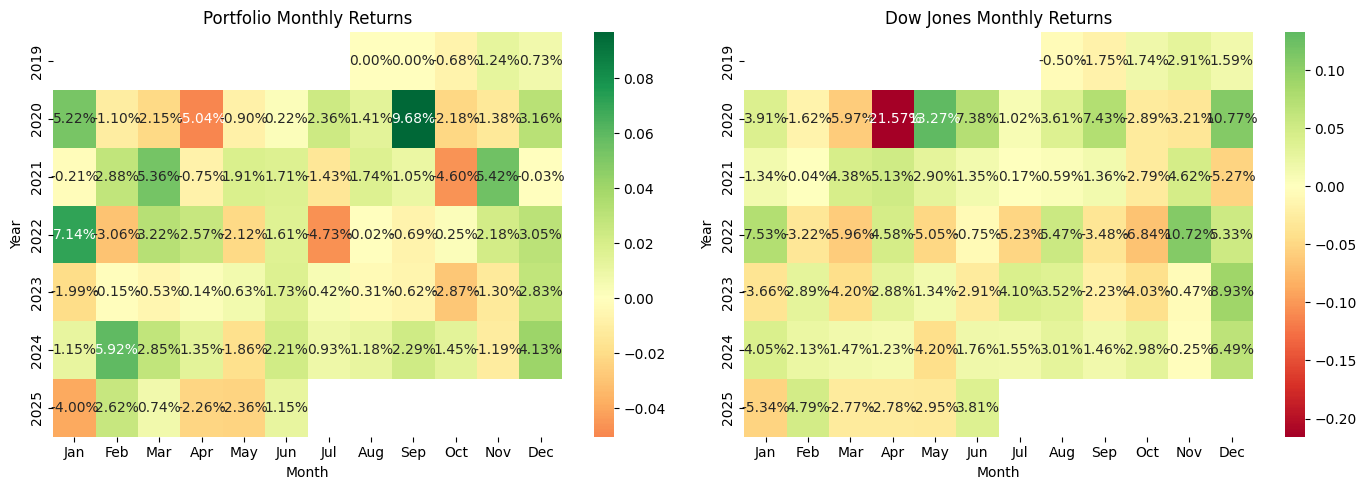

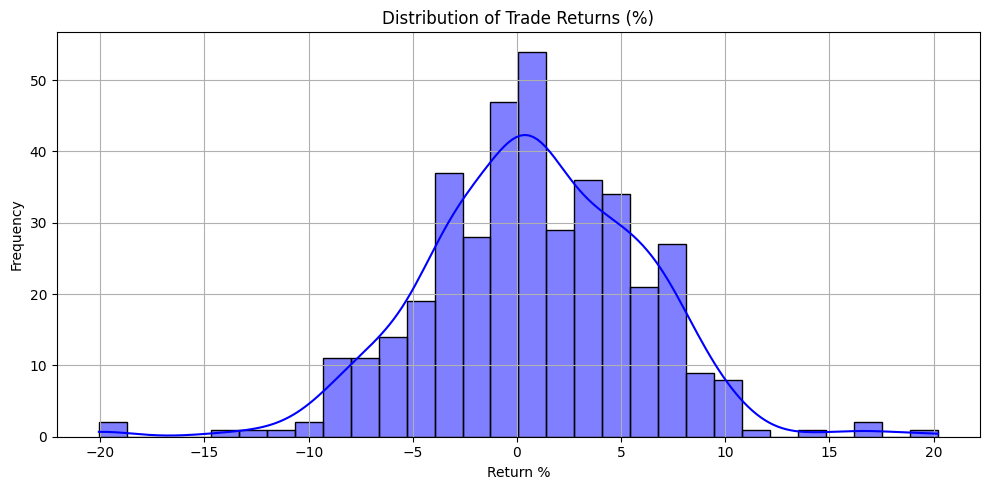

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

print("Momentum strategy with 52-week screen")

def momentum_52week_strategy(tickers, start_date, end_date):
    starting_cash = 100
    position_size = 20.0
    hold_period_days = 15
    transaction_cost_pct = 0.0003 # 3 basis points
    cash = starting_cash
    portfolio_value_daily = []
    open_positions = []
    daily_blocked_tickers = []
    all_trades = []

    print("Price data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    close = data["Close"]
    high = data["High"]
    all_dates = close.index

    high_52w_prior = high.rolling(252, min_periods=50).max().shift(1)
    total_commission_paid = 0.0

    # ---------------- MAIN LOOP ---------------- #
    for i, current_date in enumerate(all_dates):

        # ---- Process open positions ----
        new_open_positions = []
        for pos in open_positions:
            buy_idx = all_dates.get_loc(pos["buy_date"])
            if i >= buy_idx + hold_period_days:
                sell_price = close.loc[current_date, pos["ticker"]]
                exit_amount = pos["shares"] * sell_price
                ret_pct = (sell_price - pos["buy_price"]) / pos["buy_price"] * 100

                sell_commission = exit_amount * transaction_cost_pct
                total_commission_paid += sell_commission
                cash += exit_amount - sell_commission

                all_trades.append({
                    "ticker": pos["ticker"],
                    "buy_date": pos["buy_date"].strftime('%Y-%m-%d'),
                    "buy_price": round(pos["buy_price"], 4),
                    "buy_amount": round(position_size, 2),
                    "exit_date": current_date.strftime('%Y-%m-%d'),
                    "exit_price": round(sell_price, 4),
                    "exit_amount": round(exit_amount, 2),
                    "return_pct": round(ret_pct, 2),
                    "commission": round(sell_commission + pos["buy_commission"], 6)
                })
            else:
                new_open_positions.append(pos)

        open_positions = new_open_positions

        # ---- Attempt new trades ----
        unable_to_fund = []

        for ticker in tickers:
            if ticker in [pos["ticker"] for pos in open_positions]:
                continue
            if ticker not in high.columns or ticker not in close.columns:
                continue
            if pd.isna(high.loc[current_date, ticker]):
                continue

            today_high = high.loc[current_date, ticker]
            today_close = close.loc[current_date, ticker]
            prior_52w_high = high_52w_prior.loc[current_date, ticker]

            if pd.isna(prior_52w_high):
                continue

            if today_high > prior_52w_high:
                if cash >= position_size:
                    shares = position_size / today_close
                    buy_commission = position_size * transaction_cost_pct

                    total_commission_paid += buy_commission
                    cash -= (position_size + buy_commission)

                    open_positions.append({
                        "ticker": ticker,
                        "buy_date": current_date,
                        "buy_price": today_close,
                        "shares": shares,
                        "buy_commission": buy_commission
                    })
                else:
                    unable_to_fund.append(ticker)

        daily_blocked_tickers.append({
            "date": current_date,
            "tickers unable to fund": unable_to_fund
        })

        # ---- Track portfolio value ----
        holdings_value = sum(pos["shares"] * close.loc[current_date, pos["ticker"]] for pos in open_positions)
        total_value = cash + holdings_value
        total_value_no_commission = total_value + total_commission_paid

        portfolio_value_daily.append({
            "date": current_date,
            "cash": round(cash, 2),
            "invested": round(holdings_value, 2),
            "total_value": round(total_value, 2),
            "total_value_no_commission": round(total_value_no_commission, 2),
            "holdings": [pos["ticker"] for pos in open_positions]
        })

    # ---------- END MAIN LOOP ---------- #

    pv = pd.DataFrame(portfolio_value_daily)
    pv_first_of_month = pv.copy()
    pv_first_of_month['month'] = pv_first_of_month['date'].dt.to_period('M')
    pv_first_of_month = pv_first_of_month.drop_duplicates(subset='month', keep='first')

    # ---- Holdings table ----
    holdings_table = pv_first_of_month[['date', 'holdings']].copy()
    holdings_table.rename(columns={'holdings': 'tickers_in_portfolio'}, inplace=True)
    holdings_table['num_stocks_held'] = holdings_table['tickers_in_portfolio'].apply(len)

    # ---- "Unable to fund" table ----
    blocked_df = pd.DataFrame(daily_blocked_tickers)
    blocked_df['month'] = blocked_df['date'].dt.to_period('M')
    blocked_first_of_month = blocked_df.drop_duplicates(subset='month', keep='first')

    monthly_info = pd.merge(
        holdings_table,
        blocked_first_of_month[['date', 'tickers unable to fund']],
        on='date',
        how='left'
    )
    monthly_info['tickers unable to fund'] = monthly_info['tickers unable to fund'].apply(lambda x: x if isinstance(x, list) else [])

    # ---- Benchmark (DJI) ----
    dji_data = yf.download("^DJI", start=start_date, end=end_date, progress=False)
    dji_close = dji_data["Close"]
    dji_on_pv_dates = dji_close.reindex(pv_first_of_month['date'], method='ffill')
    dji_start = dji_on_pv_dates.iloc[0]
    dji_scaled = 100 * (dji_on_pv_dates / dji_start)
    pv_first_of_month['dji_value_from_100'] = dji_scaled.values

    # ---- Drawdowns ----
    pv_first_of_month['portfolio_max_to_date'] = pv_first_of_month['total_value'].cummax()
    pv_first_of_month['dji_max_to_date'] = pv_first_of_month['dji_value_from_100'].cummax()

    pv_first_of_month['portfolio_drawdown_pct'] = (
        100 * (pv_first_of_month['total_value'] - pv_first_of_month['portfolio_max_to_date']) /
        pv_first_of_month['portfolio_max_to_date']
    ).round(2)

    pv_first_of_month['dji_drawdown_pct'] = (
        100 * (pv_first_of_month['dji_value_from_100'] - pv_first_of_month['dji_max_to_date']) /
        pv_first_of_month['dji_max_to_date']
    ).round(2)

    # ---- Trades ----
    trades_df = pd.DataFrame(all_trades)
    trades_first10 = trades_df.sort_values("buy_date").head(10)
    trades_last10 = trades_df.sort_values("buy_date").tail(10)

    # ---------------- OUTPUT TABLES ---------------- #
    print("\nPortfolio Value vs Dow Jones Index (DJI) on first trading day of each month:")
    print(pv_first_of_month[['date', 'cash', 'invested', 'total_value', 'total_value_no_commission',
                             'dji_value_from_100', 'portfolio_drawdown_pct', 'dji_drawdown_pct']].to_string(index=False))

    print("\nTotal commission paid over period:", round(total_commission_paid, 2))

    print("\nComparison of Dow Jones 30 and portfolio largest drawdowns:")
    dji_drawdowns = pv_first_of_month[['month', 'dji_drawdown_pct']].sort_values(by='dji_drawdown_pct').head(3)
    portfolio_drawdowns = pv_first_of_month[['month', 'portfolio_drawdown_pct']].sort_values(by='portfolio_drawdown_pct').head(3)
    portfolio_max_dd = pv_first_of_month['portfolio_drawdown_pct'].min()

    print("\nTop 3 largest drawdowns for Dow Jones 30:")
    print(dji_drawdowns.to_string(index=False))

    print("\nPortfolio largest drawdown over entire period:", portfolio_max_dd)
    print("\nTop 3 months with largest portfolio drawdowns:")
    print(portfolio_drawdowns.to_string(index=False))

    print("\nFirst 10 trades:")
    print(trades_first10.to_string(index=False))

    print("\nLast 10 trades:")
    print(trades_last10.to_string(index=False))

    print("\nPortfolio holdings and tickers unable to fund (date is first trading day of each month):")
    print(monthly_info.to_string(index=False))

    # ---------------- VISUALIZATION 1 ---------------- #
    # ---- LINE GRAPH: PORTFOLIO vs DOW JONES ----
    plt.figure(figsize=(12, 6))
    plt.plot(pv_first_of_month['date'], pv_first_of_month['total_value'], label='Portfolio', linewidth=2)
    plt.plot(pv_first_of_month['date'], pv_first_of_month['dji_value_from_100'], label='Dow Jones 30', linewidth=2)
    plt.title("Portfolio vs Dow Jones 30")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------- VISUALIZATION 2 ---------------- #
    # ---- MONTHLY RETURNS HEATMAP ----
    print("\nGenerating Monthly Returns Heatmap...")
    df_monthly = pv_first_of_month[['date', 'total_value', 'dji_value_from_100']].copy()
    df_monthly['return_portfolio'] = df_monthly['total_value'].pct_change()
    df_monthly['return_dji'] = df_monthly['dji_value_from_100'].pct_change()
    df_monthly['Year'] = df_monthly['date'].dt.year
    df_monthly['Month'] = df_monthly['date'].dt.month  # numeric month for sorting

    # Pivot and sort months correctly
    heatmap_df = df_monthly.pivot(index='Year', columns='Month', values='return_portfolio').sort_index(axis=1)
    heatmap_df_dji = df_monthly.pivot(index='Year', columns='Month', values='return_dji').sort_index(axis=1)

    month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(heatmap_df, annot=True, fmt=".2%", cmap="RdYlGn", center=0, xticklabels=month_labels)
    plt.title("Portfolio Monthly Returns")

    plt.subplot(1, 2, 2)
    sns.heatmap(heatmap_df_dji, annot=True, fmt=".2%", cmap="RdYlGn", center=0, xticklabels=month_labels)
    plt.title("Dow Jones Monthly Returns")
    plt.tight_layout()
    plt.show()

    # ---------------- VISUALIZATION 3 ---------------- #
    # ---- DISTRIBUTION OF TRADE RETURNS ----
    if not trades_df.empty:
        plt.figure(figsize=(10, 5))
        sns.histplot(trades_df['return_pct'], bins=30, kde=True, color='blue')
        plt.title("Distribution of Trade Returns (%)")
        plt.xlabel("Return %")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No trades available for histogram.")


    return trades_df, pv, open_positions, monthly_info, pv_first_of_month


# ---------------- RUN THE MODEL ---------------- #

tickers = [
    "AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON","IBM",
    "INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PFE","PG","RTX","TRV","UNH",
    "V","VZ","WMT"
]

trades, pv, open_positions, monthly_info, pv_first_of_month = momentum_52week_strategy(
    tickers,
    "2019-06-30",
    "2025-06-30"
)
